## 'Gunting Kertas Batu' Image Classification Machine Learning Using Tensorflow
Oleh: Erick Yudha Pratama Sukku // https://www.dicoding.com/users/arcturus_18


---

*Memakai mode GPU

# 1. Mempersiapkan Dataset

Buat folder 'data' untuk menyimpan data yang akan digunakan.

In [20]:
import os

try:
  os.mkdir('Data')
except:
  print('Folder Already Exist!')

print('Completed')

Folder Already Exist!
Completed


Download file zip yang berisi dataset dari dicoding dan masukkan ke folder Data. Setelah itu extract file zip nya.

In [7]:
!wget --no-check-certificate \
 https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
 -O /content/Data/rockpaperscissors.zip

--2021-02-23 04:24:38--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/Data/rockpaperscissors.zip’

/content/Data/rockp 100%[===================>] 307.92M  1.06MB/s    in 5m 27s  

2021-02-23 04:30:06 (965 KB/s) - ‘/content/Data/rockpaperscissors.zip’ saved [322873683/322873683]



In [21]:
import zipfile
local_zip = '/content/Data/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Data')
zip_ref.close()

print('Completed')

Completed


Sebagai persiapan membuat dataset untuk melatih model nanti, bersihkan folder yang tidak dipakai di folder hasil extract zip file tadi.

In [22]:
import shutil
import os

base_dir = '/Data/rockpaperscissors'

try:
  shutil.rmtree(os.path.join(base_dir, 'rps-cv-images'))
except:
  print('file not found')

print('Completed')

Completed


Sekarang split data yang ada di folder *rock, paper, scissors* menjadi data untuk **training dan validation**. Perbandingan yang kita gunakan adalah **6:4**. Untuk melakukan ini kita akan menggunakan module *splitfolders*.

In [23]:
!pip install split-folders

In [24]:
import splitfolders

input_folder = base_dir
output = '/content/images'

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.6, .4))

images_dir = '/content/images'

train_dir = os.path.join(images_dir, 'train')
val_dir = os.path.join(images_dir, 'val')


Copying files: 0 files [00:00, ? files/s]
Copying files: 425 files [00:00, 4242.92 files/s]
Copying files: 767 files [00:00, 3954.24 files/s]
Copying files: 1209 files [00:00, 4081.43 files/s]
Copying files: 1601 files [00:00, 4029.64 files/s]
Copying files: 2188 files [00:00, 4110.27 files/s]


# 2. Melatih Model

Langkah awal di tahap preprocessing, kita buat image data generator.

In [25]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')


train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 200),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42)
 
validation_generator = test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(150, 200),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


Membuat arsitektur model dengan tipe Sequential lalu di-compile. Disini juga digunakan pretrained model Xception.

In [26]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[150, 200, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, 'softmax')
])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

model = create_model()
model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 23, 128)       0         
_________________________________________________________

Pelatihan Model

In [30]:
model.fit(train_generator,
          validation_data=validation_generator,
          epochs=26,
          validation_freq=2,
          verbose=1,
          shuffle=True
          )

Epoch 1/25
41/41 [==============================] - 10s 249ms/step - loss: 0.1303 - accuracy: 0.9543
Epoch 2/25
41/41 [==============================] - 17s 411ms/step - loss: 0.1094 - accuracy: 0.9657 - val_loss: 0.1359 - val_accuracy: 0.9612
Epoch 3/25
41/41 [==============================] - 10s 246ms/step - loss: 0.1188 - accuracy: 0.9611
Epoch 4/25
41/41 [==============================] - 17s 414ms/step - loss: 0.0879 - accuracy: 0.9756 - val_loss: 0.1272 - val_accuracy: 0.9658
Epoch 5/25
41/41 [==============================] - 10s 248ms/step - loss: 0.0811 - accuracy: 0.9688
Epoch 6/25
41/41 [==============================] - 17s 413ms/step - loss: 0.0994 - accuracy: 0.9741 - val_loss: 0.1304 - val_accuracy: 0.9635
Epoch 7/25
41/41 [==============================] - 10s 250ms/step - loss: 0.0867 - accuracy: 0.9764
Epoch 8/25
41/41 [==============================] - 17s 414ms/step - loss: 0.0636 - accuracy: 0.9809 - val_loss: 0.1391 - val_accuracy: 0.9646
Epoch 9/25
41/41 [======

# 3. Mengklasifikasikan Gambar Menggunakan Model Yang Telah Dilatih

Saving 0bioBZYFCXqJIulm.png to 0bioBZYFCXqJIulm.png
0bioBZYFCXqJIulm.png
Result >> Rock


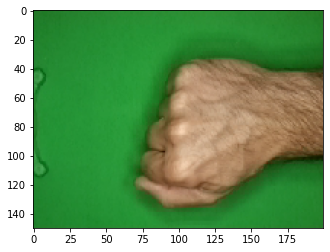

In [31]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,200))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
print(fn)
result_list = [x for x in classes[0]]
result_index = result_list.index(1)

if result_index == 0:
  result = 'Paper'
elif result_index == 1:
  result = 'Rock'
else:
  result = 'Scissors'

print(f'Result >> {result}')
